In [24]:
import tensorflow as tf
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.metrics import roc_curve, auc, multilabel_confusion_matrix
import re
import gc
import os
import glob
import keras
import pandas as pd
import numpy  as np
import itertools
from sklearn.metrics import confusion_matrix
from collections import Counter
import keras.backend as K
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense,Dropout, Input, Lambda, Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from sklearn.model_selection   import train_test_split
from keras.preprocessing.image import ImageDataGenerator

In [25]:
batch_size = 64
epochs = 20
pic_size = 48
np.random.seed(42)
tf.random.set_seed(42)

In [26]:
folder_path="/kaggle/input/face-expression-recognition-dataset/images"

In [27]:
def walk_data(mydict, folder_path):
    for (root,dirs,files) in os.walk(folder_path, topdown=False):
        if len(files)>0:
            mydict[root]=len(files)

In [28]:
train_dict = dict()
val_dict = dict()
walk_data(train_dict, folder_path + "train/")
walk_data(val_dict, folder_path + "validation/")

In [29]:
def fix_keys(mydict):
    new_dict = dict()
    for k, v in mydict.items():
        new_k = k.split('/')[-1]
        new_dict[new_k] = v
    return new_dict

In [30]:
train_dict = fix_keys(train_dict)
val_dict = fix_keys(val_dict)
print(train_dict)
print(val_dict)

{}
{}


In [31]:
datagen_train  = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg19.preprocess_input)
datagen_val = ImageDataGenerator(preprocessing_function=tf.keras.applications.vgg19.preprocess_input)

In [32]:
train_set = datagen_train.flow_from_directory("/kaggle/input/face-expression-recognition-dataset/images/train",
                                              target_size = (pic_size,pic_size),
                                              
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              shuffle=True)


val_set = datagen_val.flow_from_directory("/kaggle/input/face-expression-recognition-dataset/images/validation",
                                              target_size = (pic_size,pic_size),
                                              
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              shuffle=False)

counter = Counter(train_set.classes)                          
max_val = float(max(counter.values()))       
class_weights = {class_id : max_val/num_images for class_id, num_images in counter.items()}  

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


In [33]:
model = Sequential()
model.add(VGG19(input_shape=(pic_size, pic_size, 3), weights='imagenet', include_top=False))


In [34]:
model.add(Flatten())
model.add(Dense(512,activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(7,activation='softmax'))

In [35]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 1, 1, 512)         20024384  
_________________________________________________________________
flatten_2 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 7)                 3591      
Total params: 20,290,631
Trainable params: 20,290,631
Non-trainable params: 0
_________________________________________________________________


In [36]:
model.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

In [37]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg19 (Functional)           (None, 1, 1, 512)         20024384  
_________________________________________________________________
flatten_2 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 7)                 3591      
Total params: 20,290,631
Trainable params: 20,290,631
Non-trainable params: 0
_________________________________________________________________


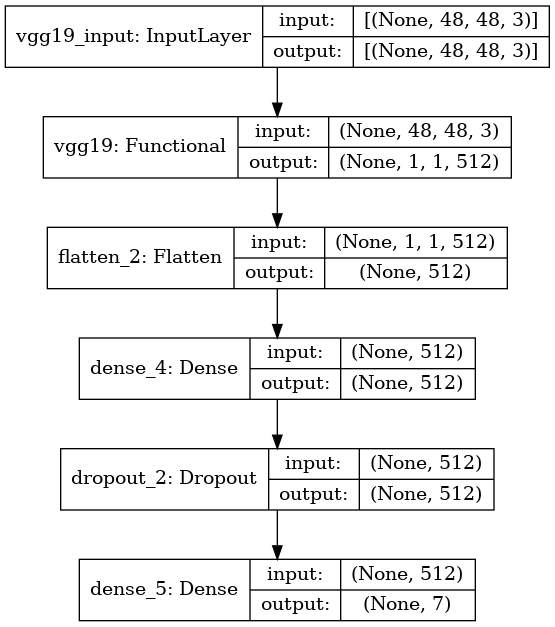

In [38]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [39]:
from keras.callbacks import ModelCheckpoint, EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=5,
                          verbose=1,
                          restore_best_weights=True
                          )
checkpoint = ModelCheckpoint("./model.h5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')


callbacks_list = [early_stopping,checkpoint]

In [40]:
history = model.fit_generator(train_set, 
                    validation_data = val_set,
                    class_weight=class_weights,
                    epochs = epochs,
                    steps_per_epoch=train_set.n//train_set.batch_size,
                   validation_steps = val_set.n//val_set.batch_size,callbacks=callbacks_list)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
450/450 [==============================] - 35s 74ms/step - loss: 0.7511 - accuracy: 0.1819 - val_loss: 0.3837 - val_accuracy: 0.2389
Epoch 2/20
450/450 [==============================] - 33s 74ms/step - loss: 0.6192 - accuracy: 0.3427 - val_loss: 0.3115 - val_accuracy: 0.4518
Epoch 3/20
450/450 [==============================] - 33s 73ms/step - loss: 0.5269 - accuracy: 0.4771 - val_loss: 0.2968 - val_accuracy: 0.4957
Epoch 4/20
450/450 [==============================] - 34s 76ms/step - loss: 0.4699 - accuracy: 0.5362 - val_loss: 0.2735 - val_accuracy: 0.5555
Epoch 5/20
450/450 [==============================] - 34s 75ms/step - loss: 0.4233 - accuracy: 0.5820 - val_loss: 0.2610 - val_accuracy: 0.5781
Epoch 6/20
450/450 [==============================] - 33s 73ms/step - loss: 0.3884 - accuracy: 0.6161 - val_loss: 0.2471 - val_accuracy: 0.6018
Epoch 7/20
450/450 [==============================] - 33s 73ms/step - loss: 0.3570 - accuracy: 0.6471 - val_loss: 0.2617 - val_accuracy:

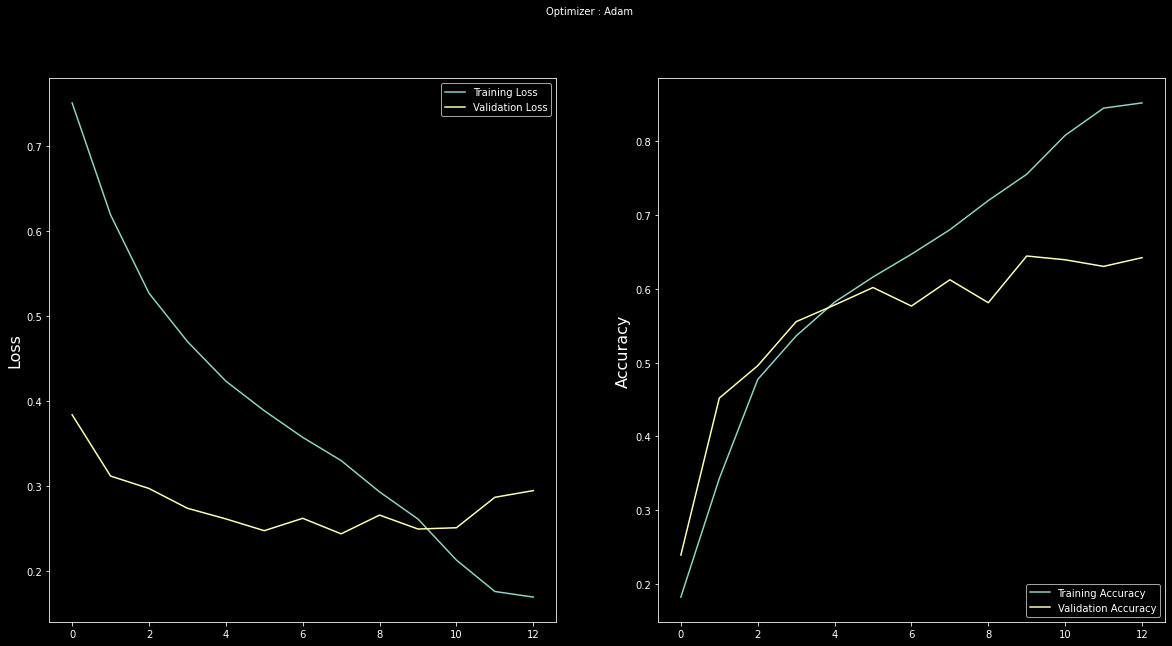

In [41]:
plt.style.use('dark_background')

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2035: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


<Figure size 432x288 with 0 Axes>

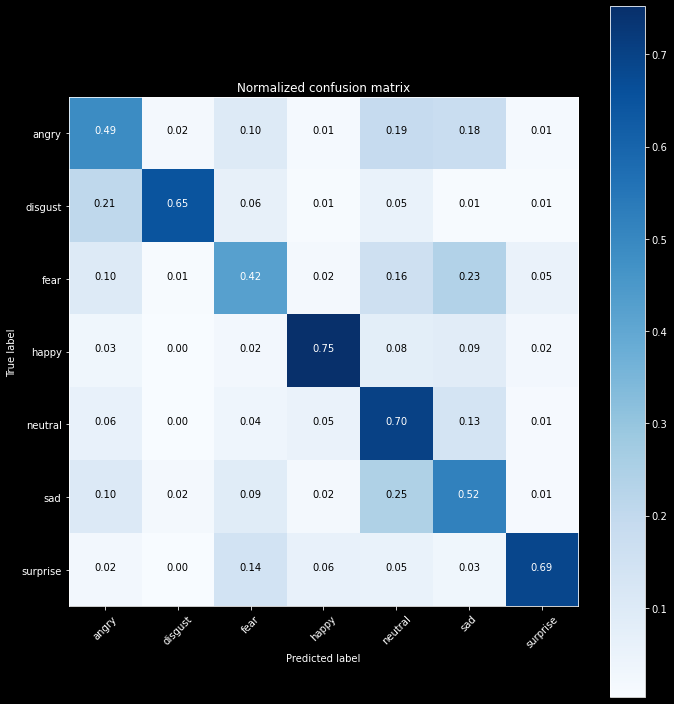

In [42]:
predictions = model.predict_generator(generator=val_set)
y_pred = [np.argmax(probas) for probas in predictions]
y_test = val_set.classes
class_names = val_set.class_indices.keys()

from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, title='Normalized confusion matrix')
plt.show()